# Connect to drive

In [ ]:
!pip install python_speech_features
!pip install webrtcvad

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=0f60019ecc7d8dd9983935407c8498dab09ca82f51bedee16ce450601bdfcb2a
  Stored in directory: /root/.cache/pip/wheels/37/01/19/e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp311-cp311-linux_x86_64.whl size=73506 sha256=c1b4654e171baceca389d4d60bf0f195567316b4eeec93fdf9c395def71ac7b5
  Stored in directory: /root/.cache/pip/wheels/94/65/3f/292d0b656be33d1c801831201c74b5f68f41a2ae465ff2ee2f
Successfully built webrtcvad


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
cd Speaker_Recognition/

/content/drive/MyDrive/Speaker_Recognition


# Load data

In [ ]:
import librosa
import numpy as np
from sklearn.mixture import GaussianMixture
import joblib
import os
from python_speech_features import mfcc
import webrtcvad
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
signal, sr = librosa.load("EnregistrementSilence.wav", sr=16000)
mfcc1 = mfcc(signal, sr)
energy = np.array([
    np.sum(np.square(mfcc1), axis=1)
])
gmm = GaussianMixture(n_components=2, covariance_type='diag', random_state=42)
gmm.fit(energy.reshape(-1, 1))
joblib.dump(gmm, "gmm1.gmm")

# Data preprocessing and MFCC features

In [ ]:
import librosa
import numpy as np
import joblib
import os
from python_speech_features import mfcc

def remove_silence(wav_file, save_path, id):

    # Load audio
    audio, sr = librosa.load(wav_file, sr=16000)

    # Load trained GMM model
    model = joblib.load("gmm1.gmm")

    mfcc_features = mfcc(audio, sr)
    energy = np.array([
        np.sum(np.square(mfcc_features), axis=1)
    ])

    # Normalize energy

    pred_prob = model.predict_proba(energy.reshape(-1, 1))
    silence_prob = [0 if x > 0.6 else 1 for x in pred_prob[:,1]]

    print("Processing complete!")
    new_mfcc = np.array([mfcc_features[i, :] for i in range(len(silence_prob)) if silence_prob[i] == 1])

    os.makedirs("MFCC/"+ save_path, exist_ok=True)
    np.save(f"MFCC/{save_path}new_mfcc{id}", new_mfcc)



In [ ]:
def frame_generator(audio, sr, frame_duration_ms=30):
    """Découpe l'audio en frames de frame_duration_ms ms (10, 20 ou 30 ms)."""
    frame_size = int(sr * frame_duration_ms / 1000)  # Taille de la frame en échantillons
    frames = [audio[i:i + frame_size] for i in range(0, len(audio), frame_size)]

    # Filtrer les frames incomplètes
    return [frame for frame in frames if len(frame) == frame_size]

def float_to_pcm16(audio_float):
    """Convertit un signal float32 (-1 à 1) en PCM 16 bits (-32768 à 32767)."""
    audio_int16 = np.int16(audio_float * 32767)  # Conversion en int16
    return audio_int16.tobytes()

def vad_filter(audio, sr, frame_duration_ms=30, mode=3):
    """Supprime le silence en utilisant WebRTC VAD."""
    vad = webrtcvad.Vad(mode)  # Mode 0-3, plus élevé = plus strict
    frames = frame_generator(audio, sr, frame_duration_ms)

    # Vérifier que l'échantillonnage est bien supporté
    if sr not in [8000, 16000, 32000, 48000]:
        raise ValueError("WebRTC VAD supporte uniquement les fréquences 8kHz, 16kHz, 32kHz, 48kHz.")

    # Convertir chaque frame en PCM 16 bits avant le traitement
    voiced_frames = [frame for frame in frames if vad.is_speech(float_to_pcm16(frame), sr)]

    return np.concatenate(voiced_frames) if voiced_frames else np.array([])
def remove_silence1(wav_file, save_path, id):

  audio, sr = librosa.load(wav_file, sr=48000)
  clean_audio = vad_filter(audio, sr)
  if clean_audio.size == 0:
      print(f"Attention : {file} est trop silencieux après VAD. Fichier ignoré.\n")
  mfcc_features = mfcc(clean_audio, sr)
  os.makedirs("MFCC/"+ save_path, exist_ok=True)
  np.save(f"MFCC/{save_path}new_mfcc{id}", mfcc_features)



In [ ]:
def remove_silence2(wav_file, save_path, id):

    # Load audio
    audio, sr = librosa.load(wav_file, sr=48000)
    non_silent_intervals = librosa.effects.split(audio, top_db=40)
    y_no_silence = np.concatenate([audio[start:end] for start, end in non_silent_intervals])
    mfcc_features = mfcc(y_no_silence, sr)
    os.makedirs("MFCC/"+ save_path, exist_ok=True)
    np.save(f"MFCC/{save_path}new_mfcc{id}", mfcc_features)

In [ ]:
import os
path = "Dataset/"
dir = os.listdir(path)
#dir = sorted([os.path.join(path, f) for f in os.listdir(path) ])
for d in dir:
    remove_silence(f"{path}{d}/Train/Train.wav",f"{d}/Train/",0)


Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!
Processing complete!


In [ ]:
import os
path = "Dataset/"
dir = os.listdir(path)
#dir = sorted([os.path.join(path, f) for f in os.listdir(path) ])
dirs = ['Test/5s/', 'Test/10s/', 'Test/15s/']
for ds in dirs:
    for d in dir:
      for i in range(1,6):
        try:
          remove_silence2(f"{path}{d}/{ds}Seg{i}.wav",f"{d}/{ds}",i)
        except:
          print(f"{path}{d}/{ds}Seg{i}.wav")
          continue


# GMM

In [ ]:
def create_gmm_model(path, save_path, num_gmm):
    mfcc_features_silence = np.load(path)
    #energy1 = np.sum(np.square(mfcc_features_silence), axis = 1)
    #energy2 = (energy1 - np.mean(energy1)) / np.std(energy1)

    gmm1 = GaussianMixture(n_components=num_gmm, covariance_type='diag', random_state=42)
    #gmm1.fit(energy1.reshape(-1,1))

    gmm1.fit(mfcc_features_silence)

    os.makedirs("GMM/"+ save_path, exist_ok=True)

    joblib.dump(gmm1, f"GMM/{save_path}/gmm_model{num_gmm}.gmm")

In [ ]:
path = "MFCC/"
dir = os.listdir(path)
#dir = sorted([os.path.join(path, f) for f in os.listdir(path) ])
num_gmms = [8, 16, 32, 64, 128, 256]
for num_gmm in num_gmms:
  for d in dir:
      create_gmm_model(f"{path}/{d}/Train/new_mfcc0.npy", f"{d}", num_gmm)

# Test

In [ ]:
def test1(mfcc_path, model_path):
    mfcc_features_silence = np.load(mfcc_path)
    #energy1 = np.sum(np.square(mfcc_features_silence), axis = 1)
    model = joblib.load(model_path)
    #score = model.score(energy1.reshape(-1,1))
    score = model.score(mfcc_features_silence)

    return score

In [ ]:
num_gmms = [8, 16, 32, 64, 128, 256]
dirsAu = ['5s', '10s', '15s']
dirs = os.listdir("MFCC/")

In [ ]:
for t in num_gmms:
    folder = f"Test/IAL/IAL{t}"
    os.makedirs(folder,  exist_ok=True)
    for a in dirsAu:
      file = ""
      for i in dirs:
        if "F" in i:
          for k in range(1,6):
            predictions = []
            for j in dirs:
              if "F" in j:
                 pred = test1(f"MFCC/{i}/Test/{a}/new_mfcc{k}.npy", f"GMM/{j}/gmm_model{t}.gmm")
                 predictions.append([j, pred])
            if predictions:
              pred_values = [p[1] for p in predictions]

              maX = np.argmax(pred_values)

              best_match, best_pred = predictions[maX]

              file += f"{i} Seg{k} {best_match}\n"
        elif "H" in i:
          for k in range(1,6):
            predictions = []
            for j in dirs:
              if "H" in j:
                 pred = test1(f"MFCC/{i}/Test/{a}/new_mfcc{k}.npy", f"GMM/{j}/gmm_model{t}.gmm")
                 predictions.append([j, pred])
            if predictions:
              pred_values = [p[1] for p in predictions]

              maX = np.argmax(pred_values)

              best_match, best_pred = predictions[maX]

              file += f"{i} Seg{k} {best_match}\n"

      with open(f"{folder}/{a}.tst", "w") as f:
        f.write(file)


0.8


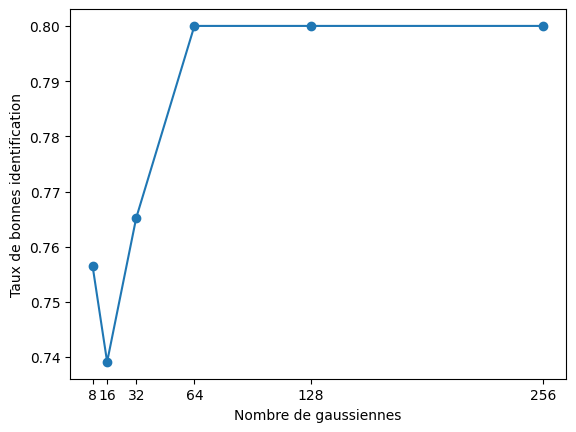

0.8260869565217391


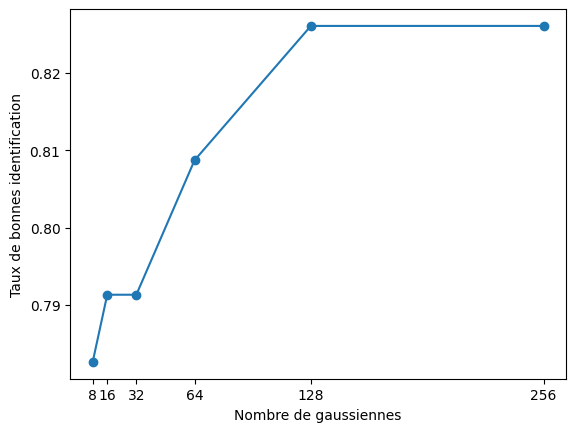

0.8782608695652174


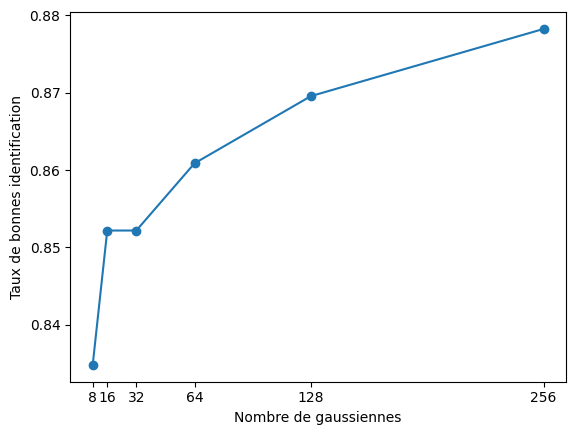

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
num_gmms = [8, 16, 32, 64, 128, 256]
folder = "Test/IAL/IAL32/5s.tst"

for i in dirsAu:
  result = []
  for t in num_gmms:
    folder = f"Test/IAL/IAL{t}/{i}.tst"
    df = pd.read_csv(folder, sep=" ", header=None)
    df.columns = ['Speaker', 'Segment', 'Prediction']
    TBI = sum(df['Speaker'] == df['Prediction'])/len(df)
    result.append(TBI)
  print(max(result))
  plt.plot(num_gmms, result, marker = "o")
  plt.xlabel('Nombre de gaussiennes')
  plt.ylabel('Taux de bonnes identification')
  plt.xticks(num_gmms)
  plt.show()

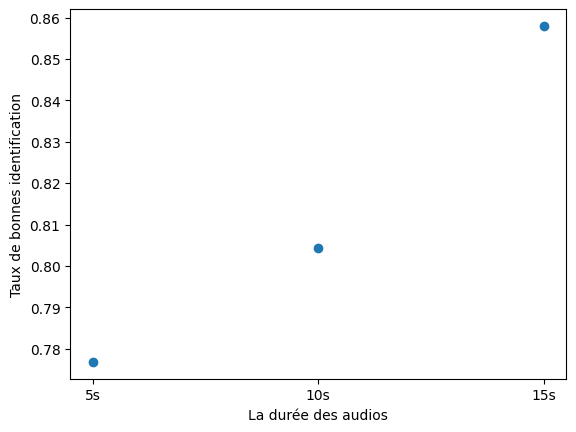

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

folder = "Test/IAL/IAL32/5s.tst"
result = []
for i in dirsAu:
  res = 0
  for t in num_gmms:
    folder = f"Test/IAL/IAL{t}/{i}.tst"
    df = pd.read_csv(folder, sep=" ", header=None)
    df.columns = ['Speaker', 'Segment', 'Prediction']
    TBI = sum(df['Speaker'] == df['Prediction'])/len(df)
    res +=TBI
  result.append(res/6)
plt.scatter(dirsAu, result)
plt.xlabel('La durée des audios')
plt.ylabel('Taux de bonnes identification')
plt.show()

In [ ]:
folder = f"Test/IAL/IAL8/5s.tst"
df = pd.read_csv(folder, sep=" ", header=None)

df.columns = ['Speaker', 'Segment', 'Prediction']
df.head()

,Speaker,Segment,Prediction
0,F3,Seg1,F3
1,F3,Seg2,F3
2,F3,Seg3,F3
3,F3,Seg4,F3
4,F3,Seg5,F3
5,F2,Seg1,F2
6,F2,Seg2,F5
7,F2,Seg3,F5
8,F2,Seg4,F5
9,F2,Seg5,F2


# Verification

In [ ]:
for g in num_gmms:
  folder = f"Test/VAL/VAL{g}"
  os.makedirs(folder,  exist_ok=True)
  for a in dirsAu :
    file =""
    for ds in dirs :
      if "F" in ds:
        for t in dirs:
          if "F" in t :
            for k in range(1,6):
                pred = test1(f"MFCC/{t}/Test/{a}/new_mfcc{k}.npy", f"GMM/{ds}/gmm_model{g}.gmm")
                file += f"{t} {ds} {round(pred, 2)}\n"
      elif "H" in ds:
        for t in dirs:
          if "H" in t :
            for k in range(1,6):
                pred = test1(f"MFCC/{t}/Test/{a}/new_mfcc{k}.npy", f"GMM/{ds}/gmm_model{g}.gmm")
                file += f"{t} {ds} {round(pred, 2)}\n"

    with open(f"{folder}/{a}.tst", "w") as f:
        f.write(file)

NameError: name 'dirsAu' is not defined

In [ ]:
import pandas as pd
folder = f"Test/VAL/VAL8/5s.tst"
df = pd.read_csv(folder, sep=" ", header=None)

df.columns = ['Test', 'Model', 'Score']
df.head(20)

,Test,Model,Score
0,F3,F3,-47.51
1,F3,F3,-48.20
2,F3,F3,-47.78
3,F3,F3,-47.48
4,F3,F3,-48.18
5,F2,F3,-51.34
6,F2,F3,-48.07
7,F2,F3,-48.81
8,F2,F3,-48.77
9,F2,F3,-52.87


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def CourbeDET(data, t, i):
    seuil = max(data["Score"]) + 0.01 if max(data["Score"]) != 1 else 1
    pas = seuil / len(data)
    print(seuil, max(data["Score"]), min(data["Score"]))
    FA = []
    FR = []
    seuils = []
    minV = min(data["Score"])

    while seuil > minV:
        FA_val = sum((data["Score"] >= seuil) & (data["Test"] != data["Model"])) / len(data)
        FR_val = sum((data["Score"] < seuil) & (data["Test"] == data["Model"])) / len(data)

        FR.append(FR_val)
        FA.append(FA_val)
        seuils.append(seuil)
        seuil += pas

    # Convert to numpy arrays for easier comparison
    FA = np.array(FA)
    FR = np.array(FR)
    seuils = np.array(seuils)

    # Find closest index where FA ≈ FR (Equal Error Rate)
    diff = np.abs(FA - FR)
    eer_index = np.argmin(diff)
    eer = round(FA[eer_index],7)
    # Plot
    plt.clf()
    plt.plot(seuils, FA, label='FA')
    plt.plot(seuils, FR, label='FR')
    plt.axvline(x=seuils[eer_index], color='r', linestyle='--', label=f'EER @ seuil={seuils[eer_index]:.2f}')
    plt.axhline(y=eer, color='g', linestyle='--', label=f"EER = {eer}")
    plt.title(f"La courbe DET ({t} {i})")
    plt.xlabel("Seuils")
    plt.ylabel("Taux")
    plt.legend()
    plt.grid(True)

    return eer


-46.24 -46.25 -79.98
-44.6 -44.61 -84.22
-44.46 -44.47 -86.57
-44.160000000000004 -44.17 -92.46
-44.080000000000005 -44.09 -95.61
-44.14 -44.15 -97.64
-46.47 -46.48 -81.21
-46.13 -46.14 -84.32
-46.0 -46.01 -87.04
-45.910000000000004 -45.92 -91.78
-45.52 -45.53 -96.47
-45.120000000000005 -45.13 -96.33
-46.72 -46.73 -78.37
-46.03 -46.04 -84.45
-45.53 -45.54 -87.73
-45.1 -45.11 -90.56
-44.830000000000005 -44.84 -96.27
-44.9 -44.91 -96.22


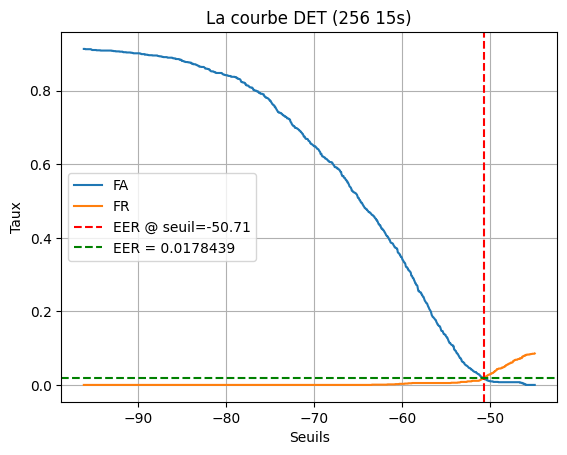

In [ ]:
dur_5 = []
dur_10 = []
dur_15 = []

for i in dirsAu:
  for t in num_gmms:
    folder = f"Test/VAL/VAL{t}/{i}.tst"
    df = pd.read_csv(folder, sep=" ", header=None)
    df.columns = ['Test', 'Model', 'Score']
    err = CourbeDET(df, t, i)
    if i == "5s":
      dur_5.append(err)
    elif i == "10s":
      dur_10.append(err)
    else:
      dur_15.append(err)

In [ ]:
print(dur_5)
print(dur_10)
print(dur_15)

[np.float64(0.0319703), np.float64(0.0289963), np.float64(0.0260223), np.float64(0.0260223), np.float64(0.0252788), np.float64(0.0252788)]
[np.float64(0.0304833), np.float64(0.0289963), np.float64(0.0275093), np.float64(0.0260223), np.float64(0.0252788), np.float64(0.0252788)]
[np.float64(0.0245353), np.float64(0.0215613), np.float64(0.0185874), np.float64(0.0193309), np.float64(0.0193309), np.float64(0.0178439)]


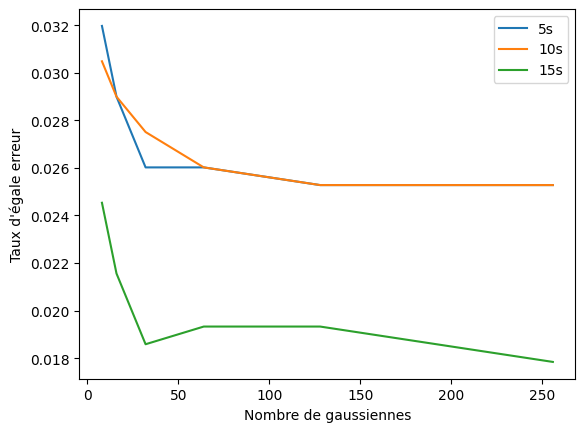

In [ ]:
import matplotlib.pyplot as plt

num_gmms = [8, 16, 32, 64, 128, 256]


plt.plot(num_gmms, dur_5, label="5s")
plt.plot(num_gmms, dur_10, label="10s")
plt.plot(num_gmms, dur_15, label="15s")
plt.ylabel('Taux d\'égale erreur')
plt.xlabel('Nombre de gaussiennes')
plt.legend()
plt.show()